In [199]:
! python3 -m pip install arch

In [200]:
import numpy as np
from scipy.stats import norm
import scipy.optimize as opt
import yfinance as yf
import pandas as pd
import datetime
import time
import matplotlib.pyplot as plt
from arch import arch_model
from sklearn.metrics import mean_squared_error as mse


In [201]:
companies = '^GSPC'
start     = datetime.datetime(2013, 7, 7)
end       = datetime.datetime(2023, 7, 7)
s_p_500   = yf.download(companies , start=start, end=end, interval='1d')

[*********************100%***********************]  1 of 1 completed


In [202]:
s_p_500.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-07-08,1634.199951,1644.680054,1634.199951,1640.459961,1640.459961,3514590000
2013-07-09,1642.890015,1654.180054,1642.890015,1652.319946,1652.319946,3155360000
2013-07-10,1651.560059,1657.920044,1647.660034,1652.619995,1652.619995,3011010000
2013-07-11,1657.410034,1676.630005,1657.410034,1675.020020,1675.020020,3446340000
2013-07-12,1675.260010,1680.189941,1672.329956,1680.189941,1680.189941,3039070000


In [203]:
print(s_p_500.pct_change())
percentage_return  = 100 * (s_p_500.pct_change()[1:]['Adj Close'])
realized_volatililty = percentage_return .rolling(5).std()
print(realized_volatililty)

                Open      High       Low     Close  Adj Close    Volume
Date                                                                   
2013-07-08       NaN       NaN       NaN       NaN        NaN       NaN
2013-07-09  0.005318  0.005776  0.005318  0.007230   0.007230 -0.102211
2013-07-10  0.005277  0.002261  0.002903  0.000182   0.000182 -0.045748
2013-07-11  0.003542  0.011285  0.005917  0.013554   0.013554  0.144579
2013-07-12  0.010770  0.002123  0.009002  0.003086   0.003086 -0.118175
...              ...       ...       ...       ...        ...       ...
2023-06-29  0.001708  0.001831  0.002695  0.004474   0.004474 -0.011411
2023-06-30  0.010857  0.013662  0.011544  0.012269   0.012269  0.061350
2023-07-03  0.006340 -0.000453  0.004488  0.001171   0.001171 -0.481507
2023-07-05 -0.001896 -0.000539 -0.001279 -0.001968  -0.001968  0.711967
2023-07-06 -0.004372 -0.007059 -0.011621 -0.007923  -0.007923  0.057256

[2517 rows x 6 columns]
Date
2013-07-09         NaN
2013-07-10 

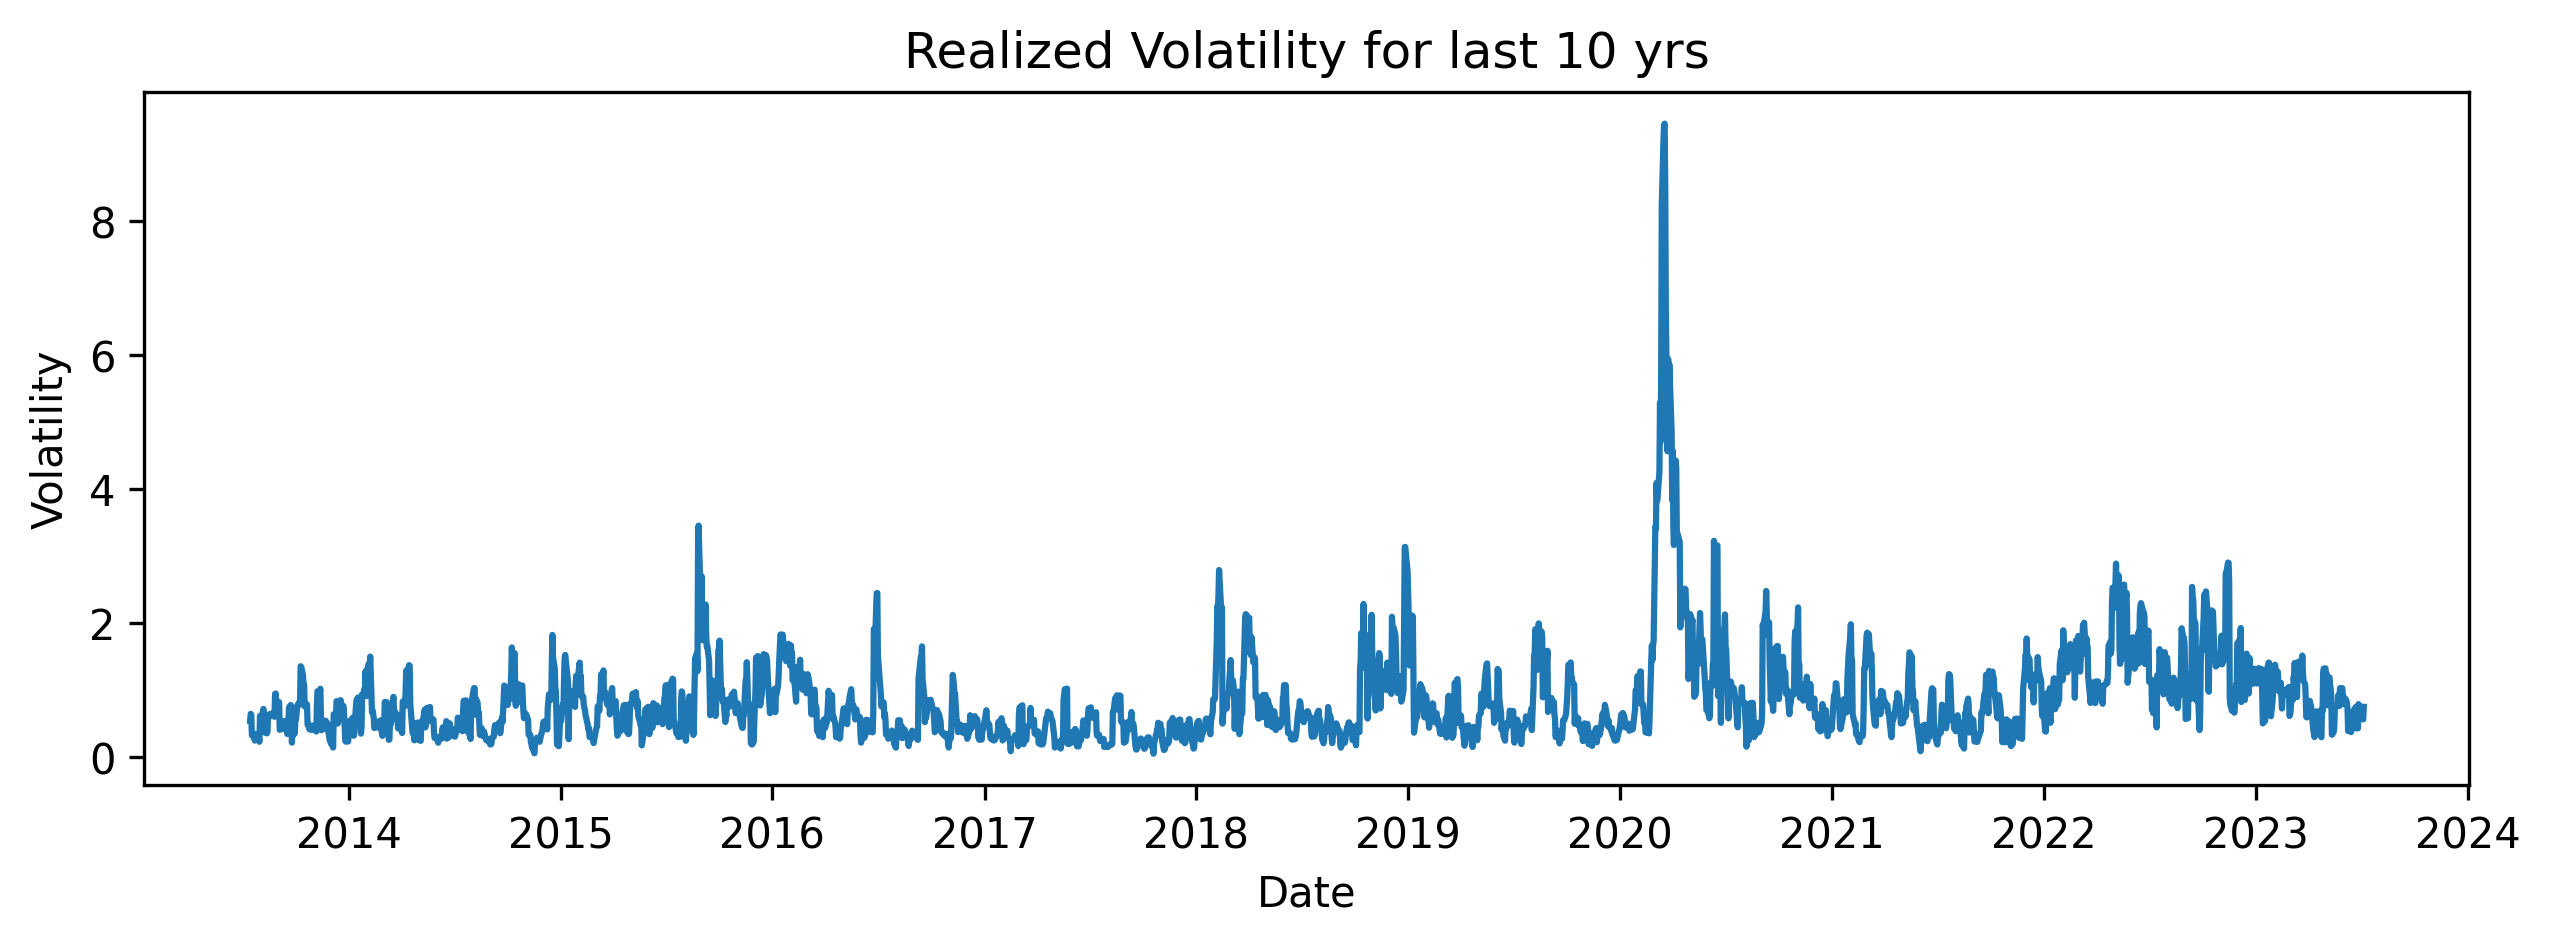

In [204]:
plt.figure(figsize=(10,3))
plt.plot((realized_volatililty).index,(realized_volatililty))
plt.title('Realized Volatility for last 10 yrs')
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.show()

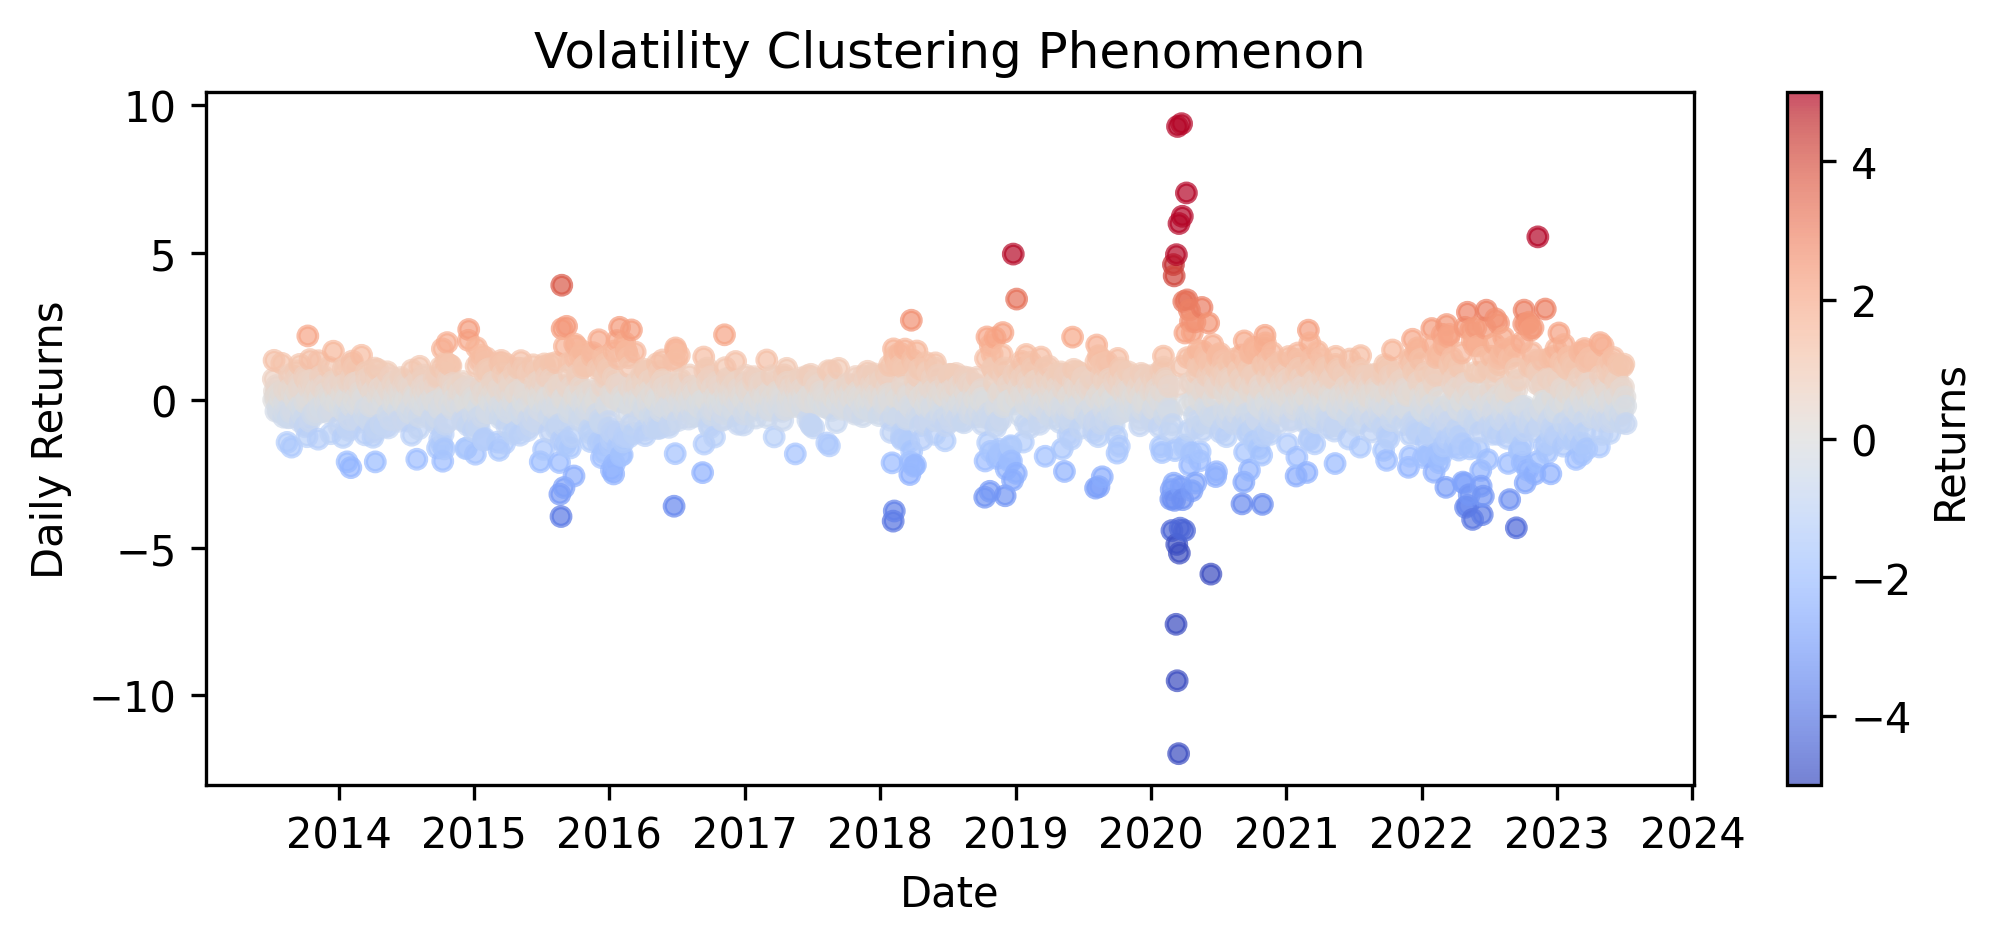

In [205]:

plt.figure(figsize=(8, 3))
plt.scatter(s_p_500.index[1:], percentage_return, s=20, c=percentage_return, cmap='coolwarm', alpha=0.7)
plt.title('Volatility Clustering Phenomenon')
plt.xlabel('Date')
plt.ylabel('Daily Returns')
plt.colorbar(label='Returns')
plt.clim(-5, 5)  # Set the colorbar limits to -5 and 5 for a wider range of colors
plt.show()







In [206]:
n = 200
fetch_observations = percentage_return.iloc[-n:].index
print(fetch_observations)

DatetimeIndex(['2022-09-19', '2022-09-20', '2022-09-21', '2022-09-22',
               '2022-09-23', '2022-09-26', '2022-09-27', '2022-09-28',
               '2022-09-29', '2022-09-30',
               ...
               '2023-06-22', '2023-06-23', '2023-06-26', '2023-06-27',
               '2023-06-28', '2023-06-29', '2023-06-30', '2023-07-03',
               '2023-07-05', '2023-07-06'],
              dtype='datetime64[ns]', name='Date', length=200, freq=None)


In [207]:
arch = arch_model(percentage_return, mean='zero', vol='ARCH', p=1).fit(disp='on')
print(arch.summary())

Iteration:      1,   Func. Count:      4,   Neg. LLF: 5672.242884503408
Iteration:      2,   Func. Count:     10,   Neg. LLF: 3539.8101102063824
Iteration:      3,   Func. Count:     15,   Neg. LLF: 3502.5958468227977
Iteration:      4,   Func. Count:     18,   Neg. LLF: 3502.5958450002136
Iteration:      5,   Func. Count:     20,   Neg. LLF: 3502.5958450002154
                        Zero Mean - ARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -3502.60
Distribution:                  Normal   AIC:                           7009.19
Method:            Maximum Likelihood   BIC:                           7020.85
                                        No. Observations:                 2516
Date:                Sun, Jul 09 2023   Df Residuals:                     2516
Time

In [208]:
# Selecting the Best Order Parameter for ARCH Model

# Create an empty list to store BIC values for different orders (p)
bic_values = []

# Iterate over different orders (p)
for i in range(1, 10):
    # Fit an ARCH model with the current order (p)
    arch = arch_model(percentage_return, mean='zero', vol='ARCH', p=i).fit(disp='on')

    # Append the BIC value of the fitted model to the list
    bic_values.append(arch.bic)

    # Check if the current BIC value is the minimum among the collected values
    if arch.bic == np.min(bic_values):
        # Update the best_param variable with the current order (p)
        best_param = i

# Refit the ARCH model using the best order parameter (best_param)
arch = arch_model(percentage_return, mean='zero', vol='ARCH', p=best_param).fit(disp='on')

# Print the summary of the best-fit ARCH model
print(arch.summary())

# Generate forecasts for future values using the best-fit ARCH model
forecast = arch.forecast(start=fetch_observations[0])
forecast_arch = forecast

Iteration:      1,   Func. Count:      4,   Neg. LLF: 5672.242884503408
Iteration:      2,   Func. Count:     10,   Neg. LLF: 3539.8101102063824
Iteration:      3,   Func. Count:     15,   Neg. LLF: 3502.5958468227977
Iteration:      4,   Func. Count:     18,   Neg. LLF: 3502.5958450002136
Iteration:      5,   Func. Count:     20,   Neg. LLF: 3502.5958450002154
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1122965.7863283814
Iteration:      2,   Func. Count:     11,   Neg. LLF: 57808.70180240911
Iteration:      3,   Func. Count:     17,   Neg. LLF: 3357.0177974109147
Iteration:      4,   Func. Count:     23,   Neg. LLF: 3338.170621655966
Iteration:      5,   Func. Count:     27,   Neg. LLF: 3338.1705675209973
Iteration:      6,   Func. Count:     31,   Neg. LLF: 3338.1705668186496
Iteration:      1,   Func. Count:      6,   Neg. LLF: 5295.957905828502
Iteration:      2,   Func. Count:     15,   Neg. LLF: 3821.9538584354514
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3

In [209]:
rmse_arch = np.sqrt(mse(realized_volatililty [-n:] / 100, np.sqrt(forecast_arch.variance.iloc[-len(fetch_observations):]/ 100)))
print('prediction accuracy of the model in estimating the volatility of the financial data. is {:.4f}'.format(rmse_arch))





prediction accuracy of the model in estimating the volatility of the financial data. is 0.1071


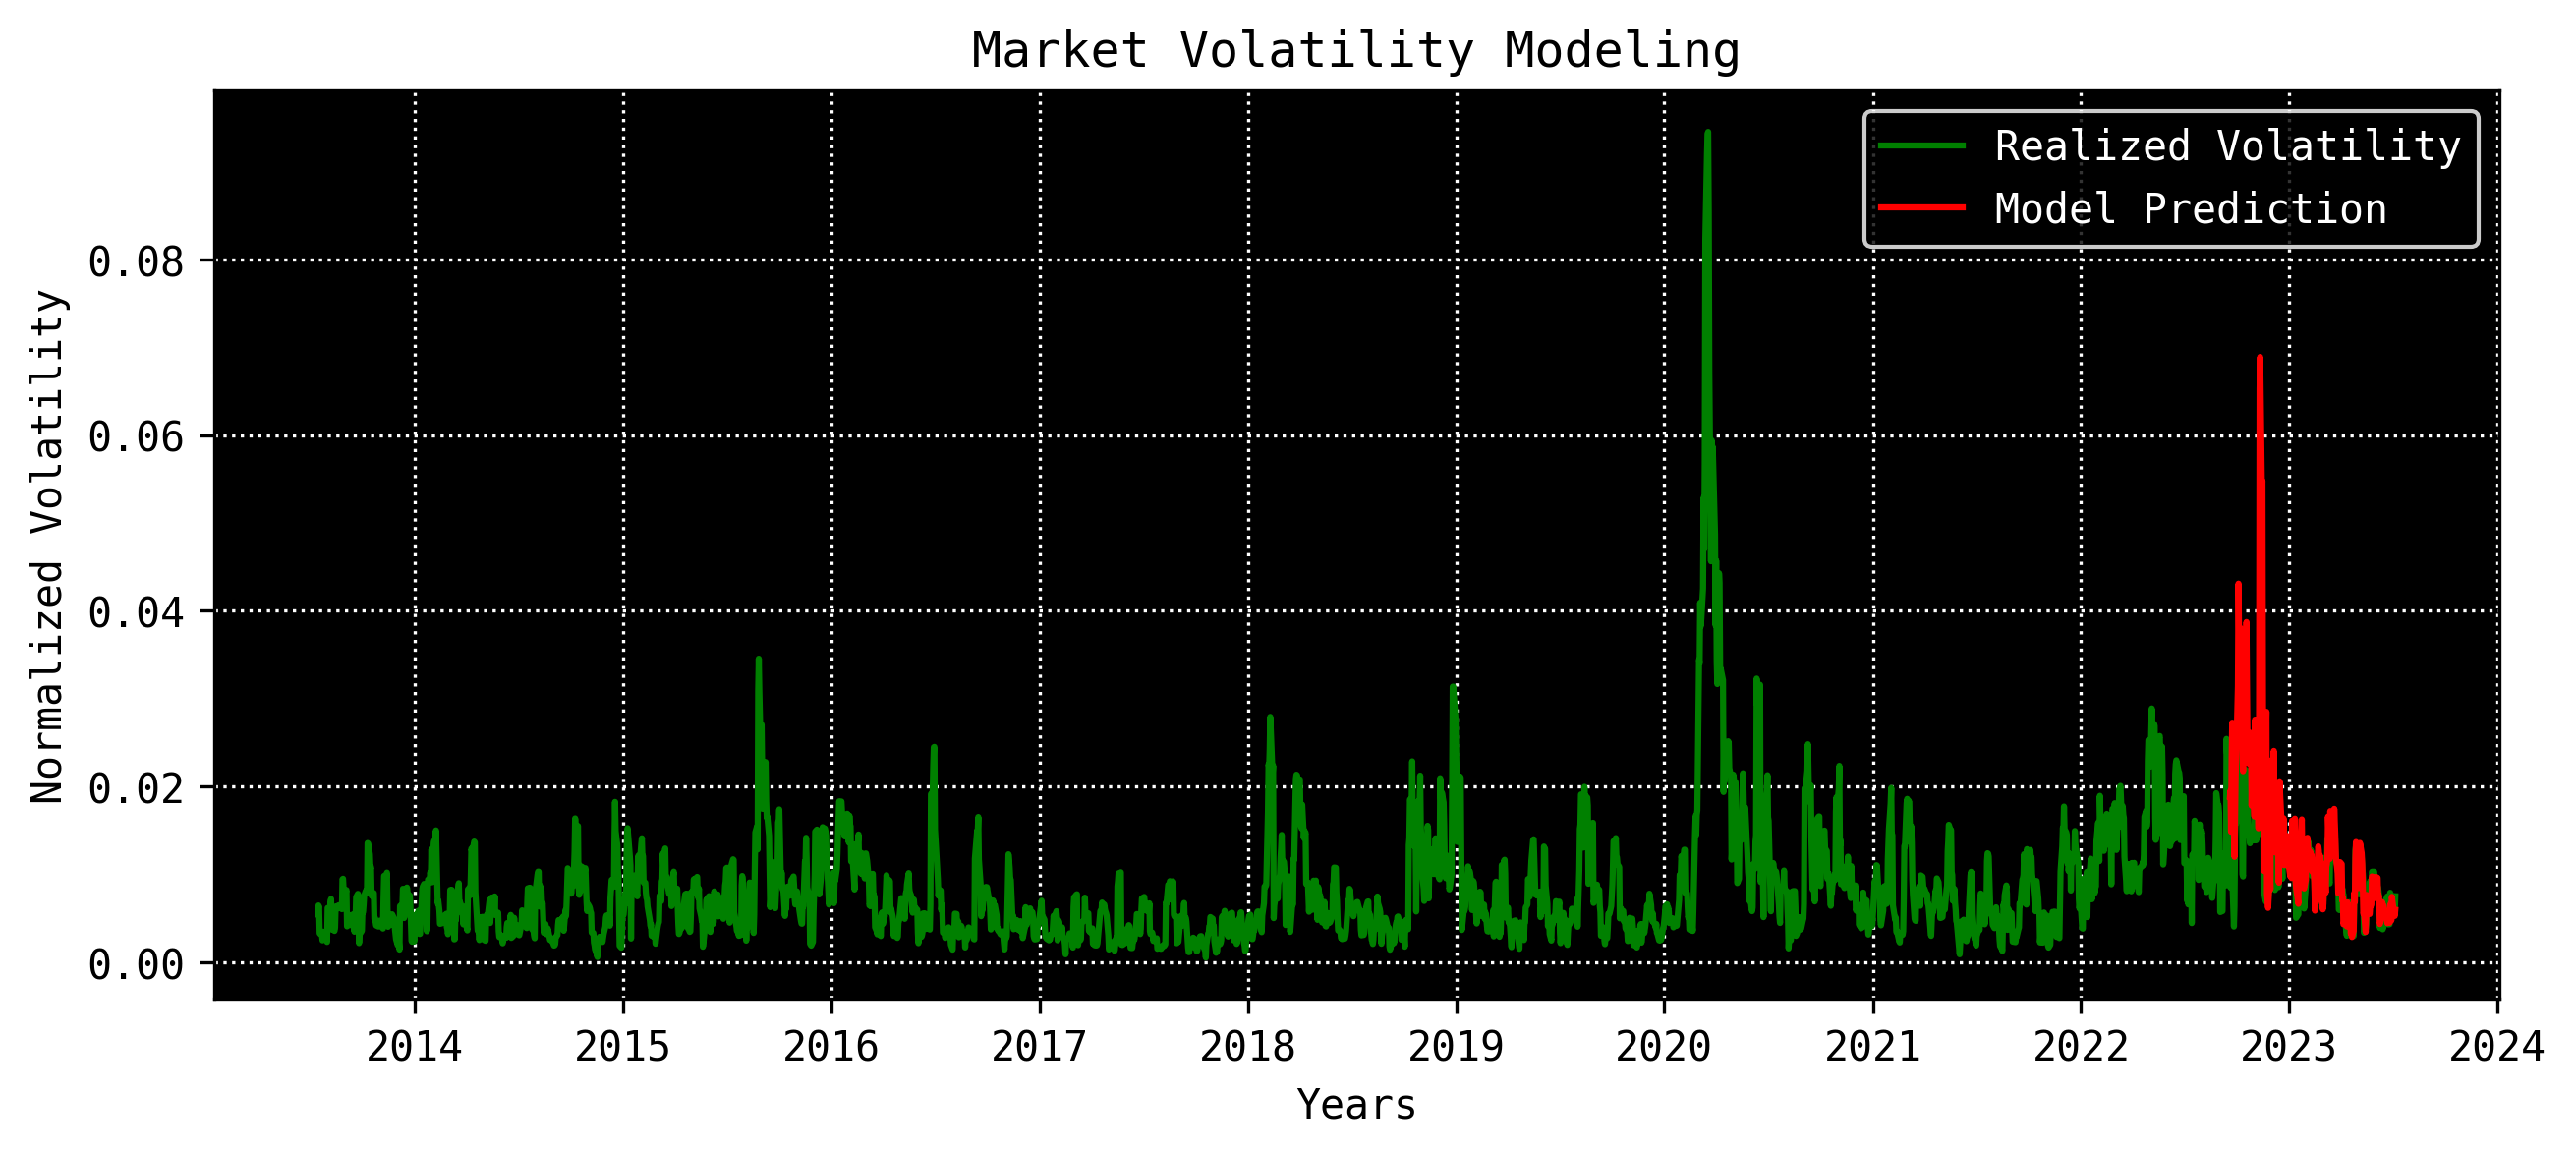

In [245]:
import matplotlib.pyplot as plt
import numpy as np

# Normalize the volatility values between 0 and 1
normalized_realized_volatility = (realized_volatililty / 100).values
normalized_predicted_volatility = (forecast_arch.variance.iloc[-len(fetch_observations):] / 100).values

# Generate a range of x-values for plotting
x_values = np.arange(len(normalized_realized_volatility))
plt.rcParams['font.family'] = 'Monospace'
plt.rcParams['axes.facecolor'] = 'black'

# Plot the volatility using green color for realized volatility and red color for volatility prediction
plt.figure(figsize=(10, 4))

plt.plot(realized_volatililty / 100, color='green', label='Realized Volatility')
plt.plot(forecast_arch.variance.iloc[-len(fetch_observations):] / 100, color='red', label='Model Prediction')

# Set the x-axis and y-axis labels, and the plot title
plt.xlabel('Years')
plt.ylabel('Normalized Volatility')
plt.title('Market Volatility Modeling', fontsize=12)

# Add a grid with white lines
plt.grid(color='white', linestyle='dotted')

# Set the legend text color to white
plt.legend(facecolor='black', edgecolor='white', labelcolor='white')

plt.show()
